## [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)

"The t-test is any statistical hypothesis test in which the test statistic follows a Student's t-distribution under the null hypothesis."

Suppose $X$ follows a normal distribution $N(\mu, \sigma^2)$.  If $\mu$ is assumed and $\sigma^2$ is estimated as $S^2 = \frac{1}{N-1}\sum{(X_i - \bar{X})^2}$, then $T(X) = \frac{\bar{X} - \mu}{S/\sqrt{N}}$ follows a t-distribution with $N-1$ degrees of freedom.

In [3]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
# default seaborn kwargs
_sns = dict(height=8.27, aspect=11.7/8.27)

Data shape: (342, 7) <class 'pandas.core.frame.DataFrame'>


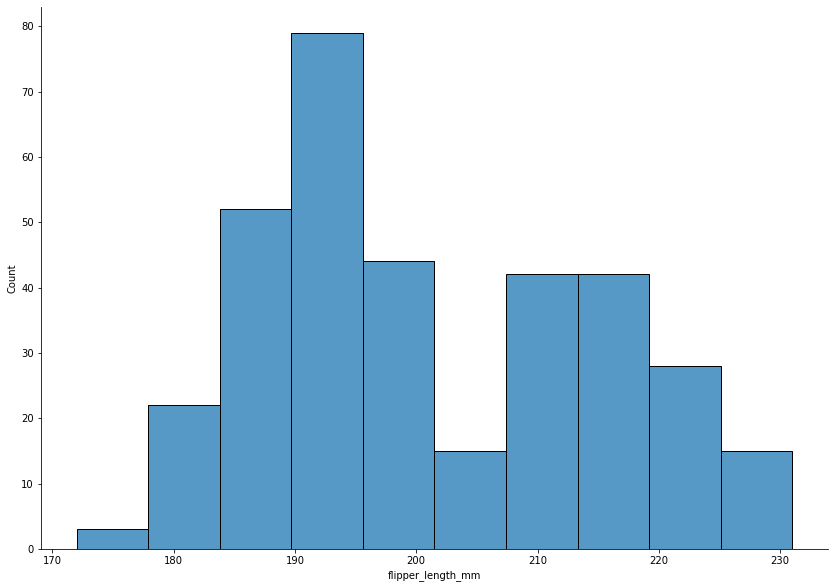

In [6]:
penguins = sns.load_dataset("penguins")
penguins.dropna(inplace=True, subset=['flipper_length_mm'])
print('Data shape:', penguins.shape, type(penguins))
sns.displot(penguins, x="flipper_length_mm", **_sns)

In [7]:
a = penguins[penguins.species == 'Adelie'].flipper_length_mm.values
b = penguins[penguins.species == 'Chinstrap'].flipper_length_mm.values

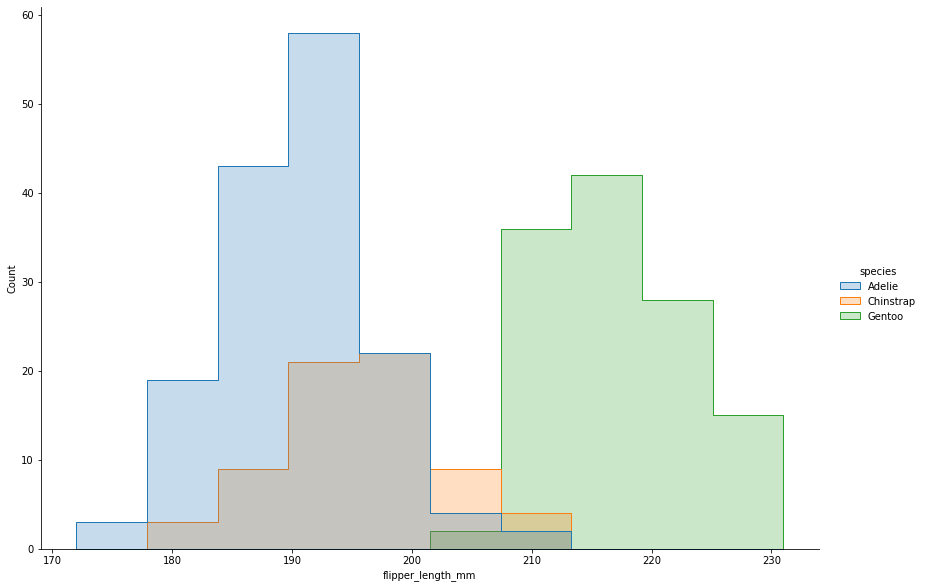

In [8]:
sns.displot(penguins, x="flipper_length_mm", hue="species", element="step", **_sns)

In [9]:
# note corrected vs uncorrected std
x = penguins['flipper_length_mm'].values
uncorr = np.sqrt(
    (
        (x - x.mean())**2/len(x)
    ).sum()
)
corr = np.sqrt(
    (
        (x - x.mean())**2/(len(x)-1)
    ).sum()
)
print(f'Uncorrected: {uncorr}; corrected: {corr}')

Uncorrected: 14.041140568589103; corrected: 14.061713679356888


In [10]:
# numpy uses uncorrected; pandas uses corrected
pd_std, np_std = penguins['flipper_length_mm'].std(), penguins['flipper_length_mm'].values.std()
print(f'Numpy: {np_std}; pandas: {pd_std}')

Numpy: 14.0411405685891; pandas: 14.061713679356894


In [11]:
# but you can use ddof in numpy
penguins['flipper_length_mm'].values.std(ddof=1)

14.061713679356886

In [12]:
# note, t distribution pdf is even
_x = np.random.normal()
scipy.stats.t.pdf(-_x, df=len(a)-1), scipy.stats.t.pdf(_x, df=len(a)-1)

(0.33415902986039187, 0.33415902986039187)

<br>

## One sample t-test

In [13]:
def get_one_sample_t_stat(x, mu):
    t_stat = (x.mean() - mu)*np.sqrt(len(x))/x.std(ddof=1)
    pval = scipy.stats.t.cdf(-abs(t_stat), df=len(x)-1)*2
    return t_stat, pval

### H<sub>0</sub>: $\mu$<sub>Adelie</sub> $=$ $\mu$
### H<sub>1</sub>: $\mu$<sub>Adelie</sub> $\ne$ $\mu$

In [14]:
a.mean()

189.95364238410596

In [15]:
mu = 189
print('DIY:', get_one_sample_t_stat(a, mu))
print('Scipy:', scipy.stats.ttest_1samp(a, mu))

DIY: (1.7919764681850072, 0.07515251322716082)
Scipy: Ttest_1sampResult(statistic=1.7919764681850074, pvalue=0.0751525132271608)


In [16]:
t_stat, p_val = get_one_sample_t_stat(a, mu)

Since this is a two-sided test, we calculate p-value as $2min\{P(T>t|H_0), P(T<t | H_0)\}$

Since $f(T) = f(-T)$, we compute $2P(-abs(t)>T|H_0)$

C:\Users\Jack\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


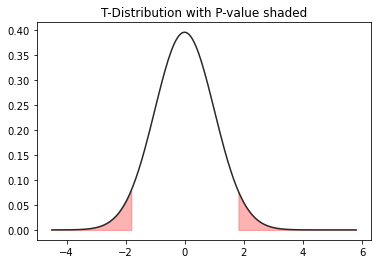

In [17]:
# plot the t distribution
ax = sns.distplot(
    scipy.stats.t.rvs(len(a)-1, size=int(1e5)), 
    fit=scipy.stats.gamma, 
    kde=False,
    hist=None
)
ax.set(title="T-Distribution with P-value shaded")

# get _x, _y from graph
_x, _y = ax.lines[0].get_xydata().T

# get x,y where less than t_stat
_ix_lt = np.argwhere(_x < -abs(t_stat))
_x_lt, _y_lt = np.squeeze(_x[_ix_lt]), np.squeeze(_y[_ix_lt])

# get x,y where greater than t_stat
_ix_gt = np.argwhere(_x > abs(t_stat))
_x_gt, _y_gt = np.squeeze(_x[_ix_gt]), np.squeeze(_y[_ix_gt])

ax.fill_between(_x_gt, _y_gt, color='red', alpha=0.3)
ax.fill_between(_x_lt, _y_lt, color='red', alpha=0.3)

<br>

## Two sample t-test

In [18]:
mean, var, skew, kurt = scipy.stats.t.stats(len(a)-1, moments='mvsk')
mean, var, skew, kurt

(array(0.), array(1.01351351), array(0.), array(0.04109589))

In [19]:
mean, var, skew, kurt = scipy.stats.t.stats(len(b)-1, moments='mvsk')
mean, var, skew, kurt

(array(0.), array(1.03076923), array(0.), array(0.0952381))

### H<sub>0</sub>: $\mu$<sub>Adelie</sub> $=$ $\mu$<sub>Chinstrap</sub>
### H<sub>1</sub>: $\mu$<sub>Adelie</sub> $\ne$ $\mu$<sub>Chinstrap</sub>

In [20]:
def get_two_sample_t_stat(x, y):
    stx, sty = x.std(ddof=0), y.std(ddof=0)
    # stx = sty = np.concatenate((x, y)).std(ddof=0)
    nx, ny = len(x), len(y)
    sp = np.sqrt(
        ( (nx-1)*stx**2 + (ny-1)*sty**2 )/ \
        (nx+ny-2)
    )
    t = (x.mean() - y.mean())/ \
        (sp * np.sqrt(1/nx + 1/ny))

    dof = (nx+ny-2)
    p_val = 2*scipy.stats.t.cdf(-abs(t), df=dof)
    return t, p_val, dof

In [21]:
def get_welchs_t_stat(x, y):
    '''
    See Welch's T-test
    '''
    stx, sty = x.std(ddof=0), y.std(ddof=0)
    # stx = sty = np.concatenate((x, y)).std(ddof=0)
    nx, ny = len(x), len(y)
    sdm = (stx**2/nx) + (sty**2/ny)
    t = (x.mean() - y.mean())/np.sqrt(sdm)
    dof = sdm**2/(
        ((stx**2)/nx)**2/(nx-1) + \
        ((sty**2)/ny)**2/(ny-1)
    )
    p_val = 2*scipy.stats.t.cdf(-abs(t), df=dof)
    return t, p_val, dof

In [22]:
# we see that given H0, this sort of observation is very unlikely (p-value ~9e-9)
print('DIY:', get_two_sample_t_stat(a,b))
print('Scipy:', scipy.stats.ttest_ind(a,b))

DIY: (-6.002400100098972, 8.075817539460438e-09, 217)
Scipy: Ttest_indResult(statistic=-5.9740408058206125, pvalue=9.378738333570485e-09)


C:\Users\Jack\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


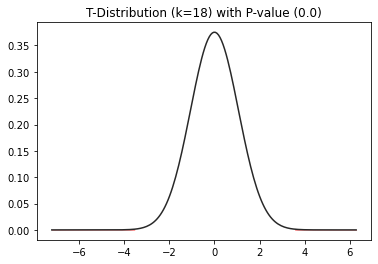

In [23]:
# just to make p val visible on graph, decrease sample size
sa, sb = np.random.choice(a, size=10), np.random.choice(b, size=10)
t_stat, pval, df = get_two_sample_t_stat(sa, sb)

# plot the t distribution
ax = sns.distplot(
    scipy.stats.t.rvs(df, size=int(1e5)), 
    fit=scipy.stats.gamma, 
    kde=False,
    hist=None
)
ax.set(title=f"T-Distribution (k={df}) with P-value ({round(pval, 2)})")

# get _x, _y from graph
_x, _y = ax.lines[0].get_xydata().T

# get x,y where less than t_stat
_ix_lt = np.argwhere(_x < -abs(t_stat))
_x_lt, _y_lt = np.squeeze(_x[_ix_lt]), np.squeeze(_y[_ix_lt])

# get x,y where greater than t_stat
_ix_gt = np.argwhere(_x > abs(t_stat))
_x_gt, _y_gt = np.squeeze(_x[_ix_gt]), np.squeeze(_y[_ix_gt])

ax.fill_between(_x_gt, _y_gt, color='red', alpha=0.3)
ax.fill_between(_x_lt, _y_lt, color='red', alpha=0.3)

### Confidence interval for mean using T statistic

For a C% confidence interval, $\exists r>0$ such that $ P(t(x) \in (-r,r) | \nu) = C $

$r$ can be found using the percent-point function (i.e. inverse of the t-distribution CDF)

In [24]:
scipy.stats.t.ppf(0.975, 10)

2.2281388519649385

In [34]:
# params
var_name = "flipper length in mm"
x = b
confidence = 95

N = len(x)

# since t distribution is even, center confidence interval on 0
percentile = 1 - 0.5*(1-confidence/100)

# use point percent function to find r
r = scipy.stats.t.ppf(percentile, df=len(x)-1)

If, with 95% confidence, $ -r < t(x) < r $ and $ t(x) = \frac{\bar{X} - \mu}{S/\sqrt{N}} $, then, equivalently, $ \mu \in (\bar{X} - \frac{rS}{\sqrt{N}}, \bar{X} + \frac{rS}{\sqrt{N}}) $

In [35]:
dx = r*x.std(ddof=1)/np.sqrt(N)

In [36]:
xl, xu = round(x.mean()-dx, 2), round(x.mean()+dx, 2)
print(f'{confidence}% confidence interval for {var_name}: ({xl}, {xu})')

95% confidence interval for flipper length in mm: (194.1, 197.55)
